In [35]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [36]:
init = State(S=1, I=1000, R=0, Q=0)
f=sum(init)

In [37]:
init /= sum(init)
init

,value
S,0.000999
I,0.999001
R,0.000000
Q,0.000000


In [38]:
def make_system(beta, gamma,omega,t_end):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=1, I=1000, R=0, Q=0)
    f=sum(init)
    init /= sum(init)

    t0 = 0
    

    return System(init=init, t0=t0, 
                  beta=beta, gamma=gamma, omega=omega, t_end=t_end)

In [39]:
tc = 0.35      # time between contacts in days 
tr = 3  # Infectious period in days
tq =4 # recovery time in days
t_end=20
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr 
omega = 1/tq  # recovery rate in per day

system = make_system(beta, gamma,omega,t_end)

In [40]:
def update1(state, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r, q = state
    quarentine = system.gamma * i
    
    recovered = system.omega * q 
    
    i -= quarentine
    q += quarentine- recovered
    r += recovered
    
    d=0
    x=0
    while d < i:
        while x < (1/beta*state.S):
            
            if flip(0.95*0.01):
                if s > 0:
                    i =+1
                    s =-1
                else:
                    s=0
                    return
            x=x+1

            
        d=d+1
        
    
   
   
       
    return State(S=s, I=i, R=r, Q=q)

In [41]:
state = update1(init, system)
state


,value
S,0.000999
I,0.666001
R,0.000000
Q,0.333000


In [42]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, system)
    return state

In [43]:
run_simulation(system, update1)

,value
S,0.000999
I,0.000200
R,0.990098
Q,0.008703


In [44]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()
    Q=TimeSeries()

    state = system.init
    t0 = system.t0
    S[t0], I[t0], R[t0],Q[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, system)
        S[t+1], I[t+1], R[t+1], Q[t+1] = state
    
    system.S = S
    system.I = I
    system.R = R
    system.Q=Q

In [45]:
system.R

AttributeError: 'System' object has no attribute 'R'

In [46]:
def plot_results(S, I, R,Q):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Recovered')
    plot(Q,':', color='yellow',label='Quarentined')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Saving figure to file chap05-fig01.pdf
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
dtype: float64


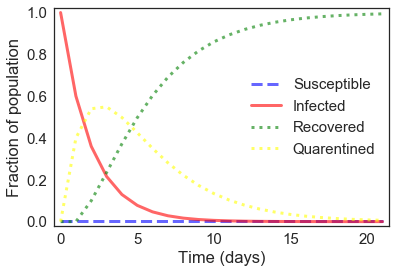

In [48]:
tc = 0.35      # time between contacts in days 
tr = 2.5  # Infectious period in days
tq =4 # recovery time in days
t_end=20
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr 
omega = 1/tq  # recovery rate in per day

system = make_system(beta, gamma,omega,t_end)
run_simulation(system, update1)
plot_results(system.S, system.I, system.R,system.Q)
savefig('chap05-fig01.pdf')
print(system.S*f)


In [49]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    frame = DataFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], system)
    
    system.results = frame

In [450]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days
tq=4
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr  
omega=1/tq# recovery rate in per day
t_end=15

sir = make_system(beta, gamma,omega,t_end)
run_simulation(system, update1)
system.results.head()

,S,I,R,Q
0,0.000999,0.999001,0.000000,0.000000
1,0.000999,0.599401,0.000000,0.399600
2,0.000999,0.359640,0.099900,0.539461
3,0.000999,0.215784,0.234765,0.548452
4,0.000999,0.129471,0.371878,0.497652


In [451]:
frame = system.results
plot_results(frame.S, frame.I, frame.R,frame.Qdef calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end])

SyntaxError: invalid syntax (<ipython-input-451-fdbf24281142>, line 2)

In [410]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [411]:
system.beta = 3
system.gamma = 0.25
run_simulation(system, update1)
print(system.beta, system.gamma, calc_total_infected(system))

3 0.25 0.0


In [20]:
def fraction_sick_at_peak(system):
    frame = system.results
    return frame.I.max()

In [21]:
def time_of_peak(system):
    frame = system.results
    return frame.I.idxmax()

In [22]:
def sick_at_end(system):
    frame = system.results
    return frame.I[system.t_end]

In [23]:
sick_at_end(system)

0.011939588462316787

In [24]:
def add_immunization(system, fraction1,fraction2):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= (fraction1*.99)+(fraction2*0.95)
    system.init.R += (fraction1*.99)+(fraction2*0.95)

In [25]:
tc = 0.35     # time between contacts in days 

tr = 3      # infectious  time in days
tq = 4
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr  
omega=1/tq
t_end=15# recovery rate in per day

system = make_system(beta, gamma,omega,t_end)
system.beta, system.gamma

(2.857142857142857, 0.3333333333333333)

In [26]:
run_simulation(system, update1)
calc_total_infected(system)

0.98884889990812752

In [27]:
system2 = make_system(beta, gamma,omega,t_end)
add_immunization(system2, 0.6,0.0)
run_simulation(system2, update1)
calc_total_infected(system2)

0.38811828958541583

Saving figure to file chap05-fig02.pdf


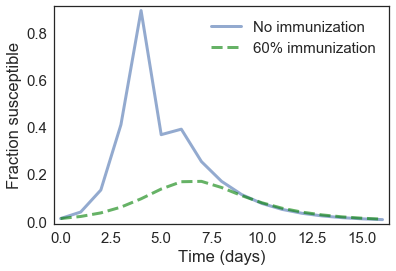

In [28]:
plot(system.results.I, '-', label='No immunization')
plot(system2.results.I, 'g--', label='60% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('chap05-fig02.pdf')

In [29]:
immunize_array = linspace(0.8, 0.97, 11)

for fraction in immunize_array:
    system = make_system(beta, gamma,omega,t_end)
    add_immunization(system, fraction,0)
    run_simulation(system, update1)
    print(fraction, calc_total_infected(system))

0.8 0.131461067174
0.817 0.106985330721
0.834 0.0841882175164
0.851 0.0640093274961
0.868 0.0470866244273
0.885 0.0336050339287
0.902 0.0233223072716
0.919 0.015725385767
0.936 0.0102135473384
0.953 0.00623132357435
0.97 0.00333100500123


In [85]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma,omega,t_end)
        add_immunization(system, fraction,0)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep
def sweep_immunity1(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma,omega,t_end)
        add_immunization(system, 0,fraction)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep
def sweep_immunity2(immunize_array,x):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma,omega,t_end)
        if fraction + x  >1:
            return sweep
        add_immunization(system, fraction,x)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep

In [86]:
immunize_array = linspace(0.1, 1, 21)
immunize_array1 = linspace(0.1, 1, 21)


infected_sweep = sweep_immunity(immunize_array)
infected_sweep1= sweep_immunity1(immunize_array)



Saving figure to file chap05-fig03.pdf


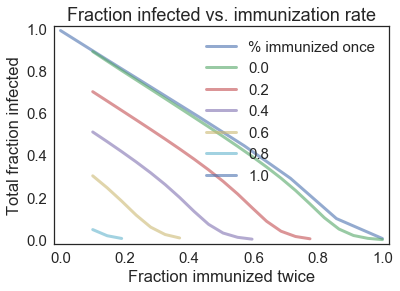

In [87]:
#plot(infected_sweep)
plot(infected_sweep2, label='% immunized once')
w=linspace(0,1,6)
for x in w:
    infected_sweep2=sweep_immunity2(immunize_array,x)
    plot(infected_sweep2, label= x)
    
decorate(xlabel='Fraction immunized twice',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=True)

savefig('chap05-fig03.pdf')

In [88]:
def sweep_immunity1(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma,omega,t_end)
        add_immunization(system, 0,fraction)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep

Saving figure to file chap05-fig03.pdf


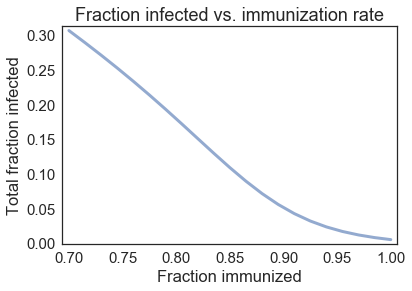

In [89]:
immunize_array = linspace(0.7, 1, 21)
infected_sweep = sweep_immunity1(immunize_array)
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('chap05-fig03.pdf')

Saving figure to file chap05-fig03.pdf


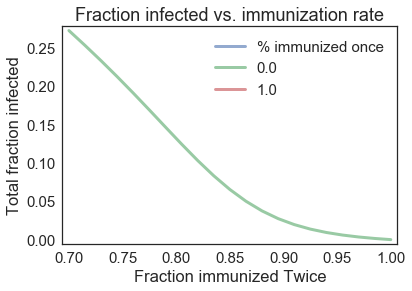

In [90]:
#plot(infected_sweep)
plot(infected_sweep2, label='% immunized once')
w=linspace(0,1,2)
for x in w:
    infected_sweep2=sweep_immunity2(immunize_array,x)
    plot(infected_sweep2, label= x)
    
decorate(xlabel='Fraction immunized Twice',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=True)

savefig('chap05-fig03.pdf')

Saving figure to file chap05-fig03.pdf


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


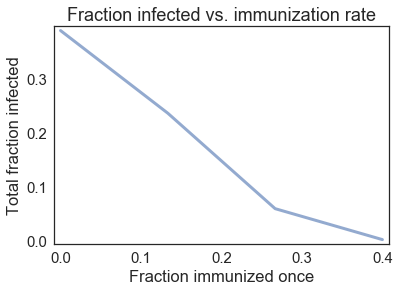

In [95]:
#plot(infected_sweep)
plot(infected_sweep2)
w=linspace(0,1,8)
infected_sweep2=sweep_immunity1(w)

decorate(xlabel='Fraction immunized once',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=True)

savefig('chap05-fig03.pdf')

In [92]:
As you can see with just one dose of vaccination there is no level off in the fraction infected and thereby no phenomenon of heard immunity.
Since anti-vaccers even when they change their mind can be given only given one dose they cause permanenet damge.

SyntaxError: invalid syntax (<ipython-input-92-18be69dd41aa>, line 1)

Saving figure to file chap05-fig03.pdf


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


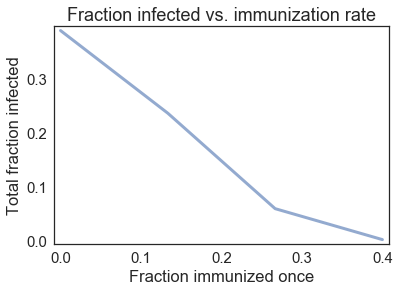

In [96]:
def sweep_immunity3(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma,omega,t_end)
        add_immunization(system, 0.6,fraction)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep

w=linspace(0.0,0.4,4)
infected_sweep2=sweep_immunity3(w)

plot(infected_sweep2)
    
decorate(xlabel='Fraction immunized once',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=True)

savefig('chap05-fig03.pdf')